In [1]:
# Make sure we're using a NVIDIA GPU
import torch
if torch.cuda.is_available():
  gpu_info = !nvidia-smi
  gpu_info = '\n'.join(gpu_info)
  if gpu_info.find("failed") >= 0:
    print("Not connected to a GPU, to leverage the best of PyTorch 2.0, you should connect to a GPU.")

  # Get GPU name
  gpu_name = !nvidia-smi --query-gpu=gpu_name --format=csv
  gpu_name = gpu_name[1]
  GPU_NAME = gpu_name.replace(" ", "_") # remove underscores for easier saving
  print(f'GPU name: {GPU_NAME}')

  # Get GPU capability score
  GPU_SCORE = torch.cuda.get_device_capability()
  print(f"GPU capability score: {GPU_SCORE}")
  if GPU_SCORE >= (8, 0):
    print(f"GPU score higher than or equal to (8, 0), PyTorch 2.x speedup features available.")
  else:
    print(f"GPU score lower than (8, 0), PyTorch 2.x speedup features will be limited (PyTorch 2.x speedups happen most on newer GPUs).")

  # Print GPU info
  print(f"GPU information:\n{gpu_info}")

else:
  print("PyTorch couldn't find a GPU, to leverage the best of PyTorch 2.0, you should connect to a GPU.")

GPU name: NVIDIA_GeForce_RTX_4060_Ti
GPU capability score: (8, 9)
GPU score higher than or equal to (8, 0), PyTorch 2.x speedup features available.
GPU information:
Sat Apr 20 01:56:27 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.171.04             Driver Version: 535.171.04   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4060 Ti     Off | 00000000:01:00.0 Off |                  N/A |
|  0%   40C    P8              13W / 165W |    804MiB / 16380MiB |      0%      Def

In [2]:
# Check available GPU memory and total GPU memory
total_free_gpu_memory, total_gpu_memory = torch.cuda.mem_get_info()
print(f"Total free GPU memory: {round(total_free_gpu_memory * 1e-9, 3)} GB")
print(f"Total GPU memory: {round(total_gpu_memory * 1e-9, 3)} GB")

Total free GPU memory: 15.895 GB
Total GPU memory: 16.864 GB


In [3]:
if GPU_SCORE >= (8, 0):
    print(
        f"[INFO] Using GPU with score: {GPU_SCORE}, enabling TensorFloat32 (TF32) computing (faster on new GPUs)"
    )
    torch.backends.cuda.matmul.allow_tf32 = True
else:
    print(
        f"[INFO] Using GPU with score: {GPU_SCORE}, TensorFloat32 (TF32) not available, to use it you need a GPU with score >= (8, 0)"
    )
    torch.backends.cuda.matmul.allow_tf32 = False

[INFO] Using GPU with score: (8, 9), enabling TensorFloat32 (TF32) computing (faster on new GPUs)


In [4]:
%pip install --quiet datasets wandb safetensors torchmetrics

Note: you may need to restart the kernel to use updated packages.


In [5]:
import wandb

wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: date3k2. Use `wandb login --relogin` to force relogin


True

In [6]:
import torch
import torchvision

device = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
# Set batch size depending on amount of GPU memory
total_free_gpu_memory_gb = round(total_free_gpu_memory * 1e-9, 3)
if total_free_gpu_memory_gb >= 16:
    # Note: you could experiment with higher values here if you like.
    BATCH_SIZE = 128
    IMAGE_SIZE = 224
    print(
        f"GPU memory available is {total_free_gpu_memory_gb} GB, using batch size of {BATCH_SIZE} and image size {IMAGE_SIZE}"
    )
else:
    BATCH_SIZE = 32
    IMAGE_SIZE = 128
    print(
        f"GPU memory available is {total_free_gpu_memory_gb} GB, using batch size of {BATCH_SIZE} and image size {IMAGE_SIZE}"
    )

GPU memory available is 15.895 GB, using batch size of 32 and image size 128


In [8]:
def create_model(num_classes=10):
    """
    Creates a ResNet50 model with the latest weights and transforms via torchvision.
    """
    model_weights = torchvision.models.ResNet50_Weights.IMAGENET1K_V2
    # transforms = model_weights.transforms()
    model = torchvision.models.resnet50(weights=model_weights)

    # Adjust the number of output features in model to match the number of classes in the dataset
    model.fc = torch.nn.Linear(in_features=2048, out_features=num_classes)
    return model

In [9]:
import torch.nn as nn
from huggingface_hub import PyTorchModelHubMixin


class RestInPeace(nn.Module, PyTorchModelHubMixin):
    def __init__(self, num_classes: int):
        super().__init__()
        self.pretrained_model = create_model(num_classes=num_classes)

    def forward(self, x):
        return self.pretrained_model(x)

## Data loaders


In [10]:
# from google.colab import drive
# drive.mount('/content/drive')

In [11]:
# !unzip ./normalized_center_data.zip

In [12]:
# from datasets import load_from_disk
# dataset = load_from_disk("normalized_center_data").train_test_split(test_size=0.2)
# train, test = dataset["train"], dataset["test"]
# from torch.utils.data import DataLoader
# train_dataloader = DataLoader(
#     dataset=train,
#     batch_size=128,
#     shuffle=True,
#     # num_workers=num_workers,
# )

In [13]:
import os
from torch.utils.data import DataLoader
from datasets import load_from_disk

dataset = load_from_disk(
    "normalized_center_data").train_test_split(test_size=0.2)


def get_train_test_dataloader(batch_size: int, num_workers: int):
    dataset = load_from_disk(
        "normalized_center_data").train_test_split(test_size=0.2)

    train, test = dataset["train"], dataset["test"]
    train_dataloader = DataLoader(
        dataset=train,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
    )

    test_dataloader = DataLoader(
        dataset=test,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
    )
    return train_dataloader, test_dataloader

## Train function


In [14]:
import time
from tqdm.notebook import tqdm as tqdm
from typing import Tuple
from safetensors.torch import load_model, save_model
from torchmetrics.classification import BinaryAccuracy, BinaryAUROC


def train_step(
    epoch: int,
    model: RestInPeace,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
    # sched: torch.optim.lr_scheduler,
    disable_progress_bar: bool = False,
):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss = 0
    auc = BinaryAUROC().to(device)
    acc = BinaryAccuracy().to(device)

    # Loop through data loader data batches
    progress_bar = tqdm(
        enumerate(dataloader),
        desc=f"Training Epoch {epoch}",
        total=len(dataloader),
        disable=disable_progress_bar,
    )

    for batch_num, batch in progress_bar:
        # Send data to target device
        X, y = batch["data"].to(device), batch["label"].to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y.float())
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        auc.update(y_pred, y)
        acc.update(y_pred, y)

        # Update progress bar
        progress_bar.set_postfix(
            {
                "train_loss": train_loss / (batch_num + 1),
                "train_acc": acc.compute().item(),
                "train_auc": auc.compute().item(),
            }
        )
        if (batch_num + 1) % 10 == 0:
            wandb.log(
                {
                    "train_loss": train_loss / (batch_num + 1),
                    "train_accuracy": acc.compute().item(),
                    "train_auc": auc.compute().item(),
                }
            )

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = acc.compute().item()
    train_auc = auc.compute().item()
    wandb.log(
        {"train_loss": train_loss, "train_accuracy": train_acc, "train_auc": train_auc}
    )
    return train_loss, train_acc, train_auc


def test_step(
    epoch: int,
    model: RestInPeace,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    device: torch.device,
):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss = 0
    auc = BinaryAUROC().to(device)
    acc = BinaryAccuracy().to(device)

    # Loop through data loader data batches
    progress_bar = tqdm(
        enumerate(dataloader),
        desc=f"Testing Epoch {epoch}",
        total=len(dataloader),
    )

    # Turn on inference context manager
    with torch.inference_mode():  # no_grad() required for PyTorch 2.0, I found some errors with `torch.inference_mode()`, please let me know if this is not the case
        # Loop through DataLoader batches
        for batch_num, batch in progress_bar:
            # Send data to target device
            X, y = batch["data"].to(device), batch["label"].to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y.float())
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            acc.update(test_pred_logits, y)

            auc.update(test_pred_logits, y)

            # Update progress bar
            progress_bar.set_postfix(
                {
                    "test_loss": test_loss / (batch_num + 1),
                    "test_acc": acc.compute().item(),
                    "test_auc": auc.compute().item(),
                }
            )

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = acc.compute().item()
    test_auc = auc.compute().item()
    wandb.log({"test_loss": test_loss, "test_accuracy": test_acc, "test_auc": test_auc})
    return test_loss, test_acc, test_auc


def train(
    model: RestInPeace,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module,
    max_lr: float,
    epochs: int,
    device: torch.device,
):
    torch.cuda.empty_cache()
    wandb.watch(model, loss_fn, log="all", log_freq=10)
    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc, train_auc = train_step(
            epoch=epoch,
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device,
        )
        test_step(
            epoch=epoch,
            model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            device=device,
        )
        early_stop_thresh = 2
        best_auc = 0
        best_epoch = -1
        if train_auc > best_auc:
            best_auc = train_auc
            best_epoch = epoch
            model.save_pretrained(f"resnet50_best_auc_{best_auc}_epoch_{best_epoch}")
        elif epoch - best_epoch >= early_stop_thresh:
            model.save_pretrained(f"resnet50_best_auc_{best_auc}_epoch_{best_epoch}")
            print(
                f"Early stopping at epoch {epoch} with best AUC of {best_auc} at epoch {best_epoch}"
            )
            break


# def test(model, dataloader):
#     test_acc = 0
#     model.eval()
#     progress_bar = tqdm(
#         enumerate(dataloader),
#         desc=f"Testing",
#         total=len(dataloader),
#     )
#     with torch.inference_mode():
#         for _, (X, y) in progress_bar:
#             X, y = X.to(device), y.to(device)
#             test_pred_logits = model(X)
#             test_pred_labels = test_pred_logits.argmax(dim=1)
#             test_acc += (test_pred_labels == y).sum().item() / len(test_pred_labels)
#         test_acc = test_acc / len(dataloader)
#         print(f"Test accuracy: {test_acc}")
#         wandb.log({"test_accuracy": test_acc})
#     # Save the model in the exchangeable ONNX format
#     save_model(model, "resnet50.safetensors")

In [15]:
config = dict(
    epochs=20,
    classes=10,
    learning_rate=2e-3,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    num_workers=os.cpu_count(),
    weight_decay=1e-4,
)
wandb.init(project="deeplearning-group-2", name="resnet-50-adamW", config=config)

In [16]:
model = RestInPeace(num_classes=config["classes"])
model.to(device)
compiled_model = torch.compile(model)
train_dataloader, test_dataloader = get_train_test_dataloader(
    config["batch_size"], config["num_workers"]
)
optimizer = torch.optim.AdamW(
    model.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"]
)
loss_fn = torch.nn.BCEWithLogitsLoss()

In [17]:
train(
    model=compiled_model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=config["epochs"],
    device=device,
    max_lr=config["learning_rate"],
)

  0%|          | 0/20 [00:00<?, ?it/s]

Training Epoch 0:   0%|          | 0/43 [00:00<?, ?it/s]

Testing Epoch 0:   0%|          | 0/11 [00:00<?, ?it/s]

Training Epoch 1:   0%|          | 0/43 [00:00<?, ?it/s]

Testing Epoch 1:   0%|          | 0/11 [00:00<?, ?it/s]

Training Epoch 2:   0%|          | 0/43 [00:00<?, ?it/s]

Testing Epoch 2:   0%|          | 0/11 [00:00<?, ?it/s]

Training Epoch 3:   0%|          | 0/43 [00:00<?, ?it/s]

Testing Epoch 3:   0%|          | 0/11 [00:00<?, ?it/s]

Training Epoch 4:   0%|          | 0/43 [00:00<?, ?it/s]

Testing Epoch 4:   0%|          | 0/11 [00:00<?, ?it/s]

Training Epoch 5:   0%|          | 0/43 [00:00<?, ?it/s]

Testing Epoch 5:   0%|          | 0/11 [00:00<?, ?it/s]

Training Epoch 6:   0%|          | 0/43 [00:00<?, ?it/s]

Testing Epoch 6:   0%|          | 0/11 [00:00<?, ?it/s]

Training Epoch 7:   0%|          | 0/43 [00:00<?, ?it/s]

Testing Epoch 7:   0%|          | 0/11 [00:00<?, ?it/s]

Training Epoch 8:   0%|          | 0/43 [00:00<?, ?it/s]

Testing Epoch 8:   0%|          | 0/11 [00:00<?, ?it/s]

Training Epoch 9:   0%|          | 0/43 [00:00<?, ?it/s]

Testing Epoch 9:   0%|          | 0/11 [00:00<?, ?it/s]

Training Epoch 10:   0%|          | 0/43 [00:00<?, ?it/s]

Testing Epoch 10:   0%|          | 0/11 [00:00<?, ?it/s]

Training Epoch 11:   0%|          | 0/43 [00:00<?, ?it/s]

Testing Epoch 11:   0%|          | 0/11 [00:00<?, ?it/s]

Training Epoch 12:   0%|          | 0/43 [00:00<?, ?it/s]

Testing Epoch 12:   0%|          | 0/11 [00:00<?, ?it/s]

Training Epoch 13:   0%|          | 0/43 [00:00<?, ?it/s]

Testing Epoch 13:   0%|          | 0/11 [00:00<?, ?it/s]

Training Epoch 14:   0%|          | 0/43 [00:00<?, ?it/s]

Testing Epoch 14:   0%|          | 0/11 [00:00<?, ?it/s]

Training Epoch 15:   0%|          | 0/43 [00:00<?, ?it/s]

Testing Epoch 15:   0%|          | 0/11 [00:00<?, ?it/s]

Training Epoch 16:   0%|          | 0/43 [00:00<?, ?it/s]

Testing Epoch 16:   0%|          | 0/11 [00:00<?, ?it/s]

Training Epoch 17:   0%|          | 0/43 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [18]:
model = RestInPeace.from_pretrained("resnet50_best_auc_0.9998378157615662_epoch_16")

Loading weights from local directory


In [21]:
model.push_to_hub("dl-resnet50")

model.safetensors:   0%|          | 0.00/94.4M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/date3k2/dl-resnet50/commit/db90572a57833aa4580e727bbb4ac3233a54e74e', commit_message='Push model using huggingface_hub.', commit_description='', oid='db90572a57833aa4580e727bbb4ac3233a54e74e', pr_url=None, pr_revision=None, pr_num=None)

In [37]:
new_model = RestInPeace.from_pretrained("date3k2/dl-resnet50").to(device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


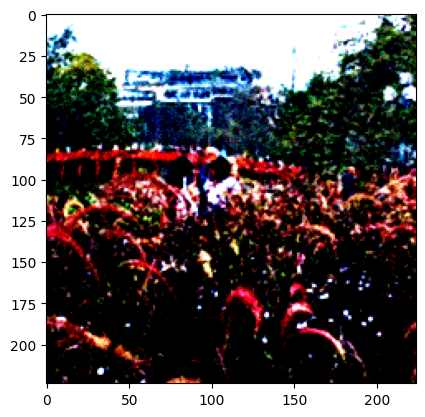

In [61]:
from datasets import load_from_disk
dataset = load_from_disk("normalized_center_data")
dataset[0]['data'].shape
# show image using pil
import matplotlib.pyplot as plt
plt.imshow(dataset[150]['data'].permute(1,2,0))

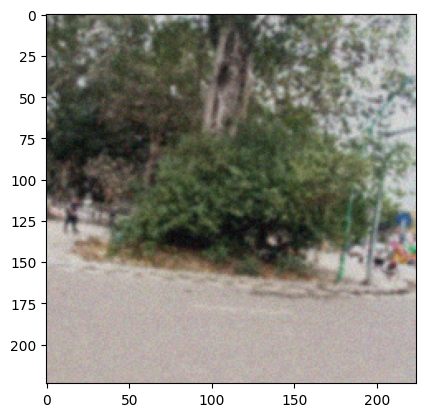

In [71]:
# Denormalize the image
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
denormalized_image = dataset[1410]['data'].permute(1,2,0) * torch.tensor(std) + torch.tensor(mean)
plt.imshow(denormalized_image)

In [70]:
img, label = dataset[153]["data"], dataset[153]["label"]
sample = img.unsqueeze(0).to(device)
new_model.eval()
with torch.inference_mode():
    output = new_model(sample)
    print(torch.where(torch.sigmoid(output) > 0.5, 1, 0))
    print(label)

tensor([[0, 1, 0, 0, 0, 0, 0, 1, 0, 0]], device='cuda:0')
tensor([0, 1, 0, 0, 0, 0, 0, 1, 0, 0])


In [58]:
def test(model, dataloader):
    test_acc = 0
    model.eval()
    progress_bar = tqdm(
        enumerate(dataloader),
        desc=f"Testing",
        total=len(dataloader),
    )
    with torch.inference_mode():
        for _, batch in progress_bar:
            X, y = batch["data"].to(device), batch["label"].to(device)
            test_pred_logits = model(X)
            test_pred_labels = torch.round(torch.sigmoid(test_pred_logits), decimals=3)
            print(test_pred_labels)
            print(y)
            break

In [59]:
test(new_model, test_dataloader)

Testing:   0%|          | 0/11 [00:00<?, ?it/s]

tensor([[0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0070, 0.9850, 0.0000, 0.0000,
         0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0010, 1.0000, 0.0010,
         0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
         0.0020],
        [0.0030, 0.9970, 0.0000, 0.0000, 0.0000, 0.0200, 0.0120, 0.4770, 0.1090,
         0.0200],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0030, 0.0010, 0.7680, 0.0020,
         0.0770],
        [1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0010, 0.9980, 0.0710,
         0.0000],
        [0.0260, 0.9760, 0.0000, 0.0450, 0.0050, 1.0000, 0.0000, 0.0000, 0.0010,
         0.0000],
        [0.0070, 0.9940, 0.0000, 0.0010, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9980,
         0.0000],
        [1